In [2]:
import os,sys
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn import linear_model
from IPython.display import display
pd.set_option('display.max_columns', 9999)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
sns.set_style("darkgrid",{"font.sans-serif":['simhei', 'Arial']})  # for chinese display
import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False  # for minus display
import datetime

In [2]:
# 读入数据
# 1.取出文件的名字
dirs=os.listdir('./网贷之家2')
inf_table=[]
for item in dirs:
    if 'info' in item:
        inf_table.append(item)

with open('./网贷之家2/%s'%inf_table[0],'r') as f:
    title=[]
    texts=f.readlines()
    text1=eval(texts[1])
    for keys in text1:
        title.append(keys)
    
    print(len(title))
    print('-----------------')
        
# 3.写入新的csv文件，将原来的字典格式整理好
wf=open('companies1.tsv','w')
title=[str(item) for item in title]
wf.write('ABCD'.join(title)+'\n')
for item in inf_table:
    with open('./网贷之家2/%s'%item,'r') as f:
        to_write=[]
        texts=f.readlines()
        text1=eval(texts[1])
        for keys in text1:
            to_write.append(text1[keys])
        content=[str(item) for item in to_write]
        wf.write('ABCD'.join(content)+'\n')

95
-----------------


In [3]:
# 最大显示
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000

In [3]:
df_train=pd.read_table('companies1.tsv',sep='ABCD',engine='python')

In [5]:
df_train.drop(['equityVoList','inspectionVoList'],inplace=True,axis=1)

In [6]:
###缺失值处理
total= df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total','Percent'])
#print(missing_data)
missing_col=missing_data[missing_data.Percent>0.6].index
df_train.drop(missing_col,axis=1,inplace=True)

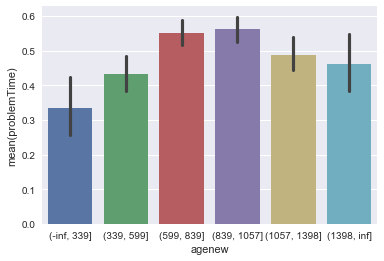

In [16]:
import numpy as np
def add_ends_to_bins(bins):
    return np.append(np.insert(bins, 0, -np.inf), np.inf)
s_amount_C = df_train['age']
q = [0.05, 0.2, 0.5, 0.8, 0.95]
bins = s_amount_C.quantile(q)
s_fea_dct_amount_C = pd.cut(s_amount_C, add_ends_to_bins(bins.values))
df_train['agenew'] = s_fea_dct_amount_C
sns.barplot(df_train['agenew'].sort_values(), df_train['problemTime']);

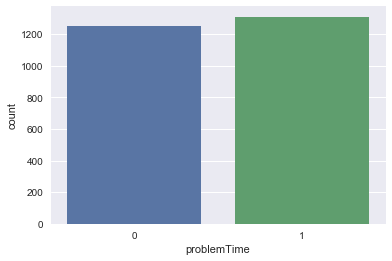

In [17]:
sns.countplot(df_train['problemTime']);

In [8]:
# 缺失值hang
df_train['is_null']=df_train.isnull().sum(axis=1)

In [18]:
df_train.groupby(df_train['problemTime']).size()

problemTime
0    1253
1    1309
dtype: int64

In [9]:
df_train.onlineDate=pd.to_datetime(df_train.onlineDate)
df_train['age']=(datetime.date.today()-df_train.onlineDate).dt.days
df_train.drop('onlineDate',inplace=True,axis=1)

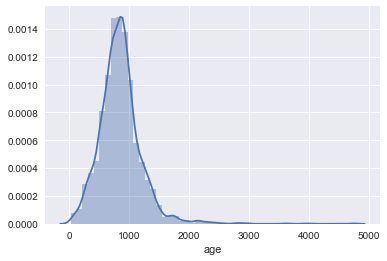

In [19]:
sns.distplot(df_train['age']);

In [10]:
df_train.loc[~df_train.problemTime.isnull(),'problemTime']=1
df_train.loc[df_train.problemTime.isnull(),'problemTime']=0

In [11]:
col_drop=['platNamePin','platId','platName','aliasName','locationAreaName','locationCityName','officeAddress','serviceTel','servicePhone','companyName','juridicalPerson','recordId','platLogoUrl','platIconUrl','platEarnings','term','termCodes','autoBid','newTrustCreditor','drawScoreDetail','serviceScoreDetail','delayScoreDetail','experienceScoreDetail','platBackgroundDetail','platBackgroundDetailExpand','platUrl','platCode']
col_text=['bidSecurity','rechargeExpense','manageExpense','withdrawExpense','vipExpense','transferExpense','securityModel','securityModelCode','businessType','payment','paymode']
col_y='bidder_num_percent','amount_percent','money_stock_percent','borrower_num_percent','loan_period','net_inflow_percent','income_rate','platEarningsCode','发展指数','成交','人气'

In [12]:
df_train2=df_train.drop(col_drop,axis=1).drop(col_text,axis=1)

In [13]:
#删除异常列
df_train2.drop(df_train2.loc[df_train2['riskFunds']=='1,0',:].index,axis=0,inplace=True)

In [14]:
total= df_train2.isnull().sum().sort_values(ascending=False)
percent = (df_train2.isnull().sum()/df_train2.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total','Percent'])
missing_col=missing_data[missing_data.Percent>0.0].index
countinous=['drawScore', 'serviceScore', 'delayScore', 'experienceScore', 'registeredCapital']
category=[]
for item in missing_col:
    if len(df_train2[str(item)].value_counts())<10:
        category.append(item)

In [15]:
for col in category:
    print(df_train2[str(col)].value_counts(dropna=False))

NaN     929
 1.0    925
 0.0    707
Name: autoBidCode, dtype: int64
 0.0    2214
NaN      193
 1.0     153
 3.0       1
Name: bankFunds, dtype: int64
0      2238
NaN     184
1       101
2        38
Name: riskFunds, dtype: int64


In [16]:
df_train2.loc[df_train2.autoBidCode.isnull(),'autoBidCode']=2.0
df_train2.loc[df_train2.bankFunds.isnull(),'bankFunds']=2.0
df_train2.loc[df_train2.riskFunds.isnull(),'riskFunds']=3

In [17]:
for col in countinous:
    df_train2[str(col)]=df_train2[str(col)].fillna(0)

In [18]:
#格式转换
object_col=df_train2.dtypes[df_train2.dtypes=='object'].index
df_train2.loc[:,object_col]
for item in object_col:
    df_train2[str(item)]=df_train2[str(item)].astype(float)

In [19]:
from sklearn import preprocessing
import numpy as np
df_y=df_train2.loc[:,'platStatus']
df_y1=df_train2.loc[:,'problem']
df_train3=df_train2.drop('problemTime',axis=1).drop('platStatus',axis=1).drop('problem',axis=1)

In [20]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
%matplotlib inline
from matplotlib.pylab import rcParams
from sklearn.model_selection import train_test_split
from sklearn.metrics import label_ranking_average_precision_score
from sklearn.metrics import accuracy_score

X_train,X_test,y_train,y_test=train_test_split(df_train3,df_y,random_state=1,test_size=0.3)

clf=RandomForestClassifier()
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
accuracy_score = accuracy_score(y_test, y_pred)
print(accuracy_score)

0.628088426528


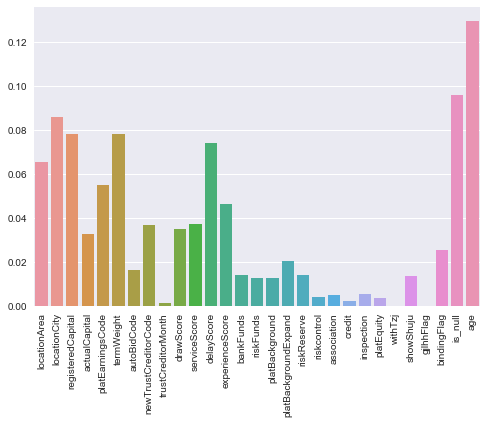

In [21]:
import seaborn as sns
import matplotlib.pylab as plt
ax=sns.barplot(x=df_train3.columns,y=clf.feature_importances_)
plt.setp(ax.get_xticklabels(), rotation=90)
# plt.show()
plt.savefig('feature_importances.jpg')

In [23]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

model_knn = KNeighborsClassifier(n_neighbors=10) # KNN, k=10
#model_lg = LogisticRegression() # logistic Regression
model_nb = MultinomialNB() # Naive Bayes
model_dt = DecisionTreeClassifier(random_state=0) # Decision Tree
model_rf = RandomForestClassifier(n_estimators=50, random_state=0) # Random Forest: 50 trees
model_ada = AdaBoostClassifier(n_estimators=50, random_state=0) # Adaboost: 50 trees

models = []
models.append(model_knn)
#models.append(model_lg)
models.append(model_nb)
models.append(model_dt)
models.append(model_rf)
models.append(model_ada)

for model in models:
    print(model)
    # train model
    %time model.fit(X_train, y_train)
    # predicted classes of testing data
    y_pred_class = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print("accuracy:",accuracy)
    

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')
CPU times: user 6.99 ms, sys: 901 µs, total: 7.89 ms
Wall time: 7.81 ms
accuracy: 0.628088426528
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
CPU times: user 4.65 ms, sys: 1.69 ms, total: 6.35 ms
Wall time: 11.4 ms
accuracy: 0.628088426528
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=0, splitter='best')
CPU times: user 27.9 ms, sys: 437 µs, total: 28.4 ms
Wall time: 24.3 ms
accuracy: 0.628088426528
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_spli

In [66]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

In [118]:
def modelfit(alg, df_train3, df_y1,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        extra = {'num_class': 9}
        xgb_param.update(extra)
        xgtrain = xgb.DMatrix(df_train3.values, label=df_y1.values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=xgb_param['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(df_train3, df_y1,eval_metric='auc')
        
#     #Predict training set:
    dtrain_predictions = alg.predict(df_train3)
#     dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(df_y1.values, dtrain_predictions))
#     print ("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Disbursed'], dtrain_predprob))
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

Index(['locationArea', 'locationCity', 'registeredCapital', 'actualCapital',
       'platEarningsCode', 'termWeight', 'autoBidCode', 'newTrustCreditorCode',
       'trustCreditorMonth', 'drawScore', 'serviceScore', 'delayScore',
       'experienceScore', 'bankFunds', 'riskFunds', 'platBackground',
       'platBackgroundExpand', 'riskReserve', 'riskcontrol', 'association',
       'credit', 'inspection', 'platEquity', 'withTzj', 'showShuju',
       'gjlhhFlag', 'bindingFlag', 'is_null', 'age'],
      dtype='object')

Model Report
Accuracy : 0.8938


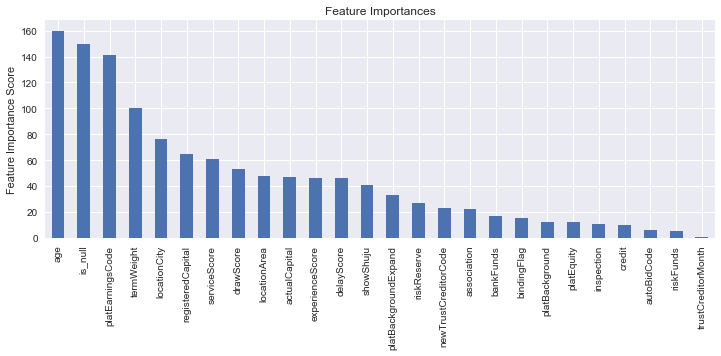

In [71]:
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
predictors=df_train3.columns
print(predictors)
modelfit(xgb1, df_train3, df_y1)

In [78]:
param_test1 = {
 'max_depth':[3,5,7,9],
 'min_child_weight':[1,3,5,7]
}
# print(param_test1['max_depth'])
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(df_train3,df_y1)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.90802, std: 0.00851, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.90694, std: 0.01043, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 0.90554, std: 0.00862, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.90324, std: 0.00974, params: {'max_depth': 5, 'min_child_weight': 7},
  mean: 0.90764, std: 0.00723, params: {'max_depth': 6, 'min_child_weight': 1},
  mean: 0.90581, std: 0.00814, params: {'max_depth': 6, 'min_child_weight': 3},
  mean: 0.90527, std: 0.00924, params: {'max_depth': 6, 'min_child_weight': 5},
  mean: 0.90100, std: 0.00880, params: {'max_depth': 6, 'min_child_weight': 7},
  mean: 0.90565, std: 0.00755, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: 0.90385, std: 0.00813, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: 0.90224, std: 0.00941, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: 0.89879, std: 0.00838, params: {'max_depth': 7, 'min_child_weight': 7},
  mean: 0.90529, std: 0.00853, params: {

In [125]:
import xgboost as xgb
X_train,X_test,y_train,y_test=train_test_split(df_train3,df_y,random_state=1,test_size=0.3)
dtrain = xgb.DMatrix(X_train, label=y_train)
xgb2={'max_depth': 5, 'eta': 0.3, 'silent': 1, 'objective': 'multi:softmax', 'nthread': 4, 'subsample': 0.8, 'gamma': 0, 'num_class':9}
clf=xgb.train(xgb2, dtrain, 100)
# clf.save_model(name)
pred = clf.predict(xgb.DMatrix(X_test))
print ("Accuracy : %.4g" % metrics.accuracy_score(y_test, pred))

# #Fit the algorithm on the data
#     alg.fit(df_train3, df_y1,eval_metric='auc')
        
# #     #Predict training set:
#     dtrain_predictions = alg.predict(df_train3)
# #     dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
#     #Print model report:
#     print ("\nModel Report")
    
# #     print ("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Disbursed'], dtrain_predprob))
                    


Accuracy : 0.6216


In [132]:
param_test1 = {
 'max_depth':[1,3,5,7,9],
 'min_child_weight':[1,3,5,7,9]
}
# print(param_test1['max_depth'])
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'multi:softmax', nthread=4, scale_pos_weight=1, seed=27), 

param_grid = param_test1, scoring='accuracy',n_jobs=4,iid=False, cv=5)
gsearch1.fit(df_train3,df_y)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.63531, std: 0.00832, params: {'max_depth': 1, 'min_child_weight': 1},
  mean: 0.63531, std: 0.00807, params: {'max_depth': 1, 'min_child_weight': 3},
  mean: 0.63726, std: 0.00766, params: {'max_depth': 1, 'min_child_weight': 5},
  mean: 0.63806, std: 0.01224, params: {'max_depth': 1, 'min_child_weight': 7},
  mean: 0.63884, std: 0.01196, params: {'max_depth': 1, 'min_child_weight': 9},
  mean: 0.65482, std: 0.00639, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.64938, std: 0.01162, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.64897, std: 0.00726, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 0.64938, std: 0.00965, params: {'max_depth': 3, 'min_child_weight': 7},
  mean: 0.64936, std: 0.01035, params: {'max_depth': 3, 'min_child_weight': 9},
  mean: 0.65252, std: 0.01226, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.64706, std: 0.01047, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 0.64589, std: 0.01590, params: {

In [133]:
param_test1 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
# print(param_test1['max_depth'])
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'multi:softmax', nthread=4, scale_pos_weight=1, seed=27), 

param_grid = param_test1, scoring='accuracy',n_jobs=4,iid=False, cv=5)
gsearch1.fit(df_train3,df_y)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.65252, std: 0.01226, params: {'gamma': 0.0},
  mean: 0.64784, std: 0.01157, params: {'gamma': 0.1},
  mean: 0.64666, std: 0.01105, params: {'gamma': 0.2},
  mean: 0.64940, std: 0.01211, params: {'gamma': 0.3},
  mean: 0.64864, std: 0.01414, params: {'gamma': 0.4}],
 {'gamma': 0.0},
 0.6525249930924932)

Accuracy : 0.6502


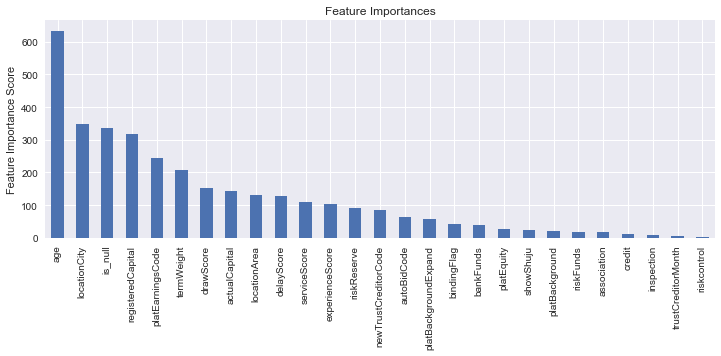

In [138]:
# 模型调整完成后进行参数的更新
import xgboost as xgb
X_train,X_test,y_train,y_test=train_test_split(df_train3,df_y,random_state=1,test_size=0.3)
dtrain = xgb.DMatrix(X_train, label=y_train)
xgb3={'max_depth': 3,'min_child_weight': 1, 'eta': 0.3, 'silent': 1, 'colsample_bytree': 0.8,'objective': 'multi:softmax', 'nthread': 4, 'subsample': 0.8, 'gamma': 0, 'num_class':9}
clf=xgb.train(xgb3, dtrain, 100)
# clf.save_model(name)
pred = clf.predict(xgb.DMatrix(X_test))
print ("Accuracy : %.4g" % metrics.accuracy_score(y_test, pred))
feat_imp = pd.Series(clf.get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')


In [139]:
param_test1 = {
 'subsample':[i/100.0 for i in range(75,90,5)],
 'colsample_bytree':[i/100.0 for i in range(75,90,5)]
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'multi:softmax', nthread=4, scale_pos_weight=1, seed=27), 

param_grid = param_test1, scoring='accuracy',n_jobs=4,iid=False, cv=5)
gsearch1.fit(df_train3,df_y)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.64001, std: 0.01190, params: {'colsample_bytree': 0.75, 'subsample': 0.75},
  mean: 0.64665, std: 0.00906, params: {'colsample_bytree': 0.75, 'subsample': 0.8},
  mean: 0.64782, std: 0.01021, params: {'colsample_bytree': 0.75, 'subsample': 0.85},
  mean: 0.64510, std: 0.00961, params: {'colsample_bytree': 0.8, 'subsample': 0.75},
  mean: 0.65252, std: 0.01226, params: {'colsample_bytree': 0.8, 'subsample': 0.8},
  mean: 0.64471, std: 0.01070, params: {'colsample_bytree': 0.8, 'subsample': 0.85},
  mean: 0.64666, std: 0.01149, params: {'colsample_bytree': 0.85, 'subsample': 0.75},
  mean: 0.65096, std: 0.01186, params: {'colsample_bytree': 0.85, 'subsample': 0.8},
  mean: 0.64510, std: 0.00971, params: {'colsample_bytree': 0.85, 'subsample': 0.85}],
 {'colsample_bytree': 0.8, 'subsample': 0.8},
 0.6525249930924932)

In [140]:
param_test1 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'multi:softmax', nthread=4, scale_pos_weight=1, seed=27), 

param_grid = param_test1, scoring='accuracy',n_jobs=4,iid=False, cv=5)
gsearch1.fit(df_train3,df_y)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.65135, std: 0.01194, params: {'reg_alpha': 1e-05},
  mean: 0.64199, std: 0.01230, params: {'reg_alpha': 0.01},
  mean: 0.64823, std: 0.01440, params: {'reg_alpha': 0.1},
  mean: 0.65134, std: 0.00935, params: {'reg_alpha': 1},
  mean: 0.58453, std: 0.01654, params: {'reg_alpha': 100}],
 {'reg_alpha': 1e-05},
 0.6513462111671495)

Accuracy : 0.6671


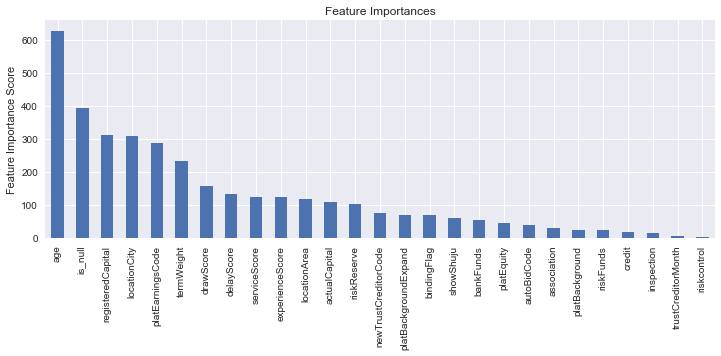

In [144]:
# 模型调整完成后进行参数的更新2
import xgboost as xgb
X_train,X_test,y_train,y_test=train_test_split(df_train3,df_y,random_state=1,test_size=0.3)
dtrain = xgb.DMatrix(X_train, label=y_train)
xgb4={'max_depth': 3,'min_child_weight': 1,'reg_alpha': 1e-05, 'eta': 0.1, 'silent': 1, 'colsample_bytree': 0.8,'objective': 'multi:softmax', 'nthread': 4, 'subsample': 0.8, 'gamma': 0, 'num_class':9}
clf=xgb.train(xgb4, dtrain, 100)
# clf.save_model(name)
pred = clf.predict(xgb.DMatrix(X_test))
print ("Accuracy : %.4g" % metrics.accuracy_score(y_test, pred))
feat_imp = pd.Series(clf.get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

In [149]:
# part3: 预期收益预测
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 999999)
pd.set_option('display.max_columns', 999999)
#pd.set_option('precision', 3)
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid",{"font.sans-serif":['simhei', 'Arial']})  # for chinese display
import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False  # for minus display
import datetime
from IPython.display import display
%matplotlib inline

from fbprophet import Prophet

Which plantform you want to see? 拍拍贷


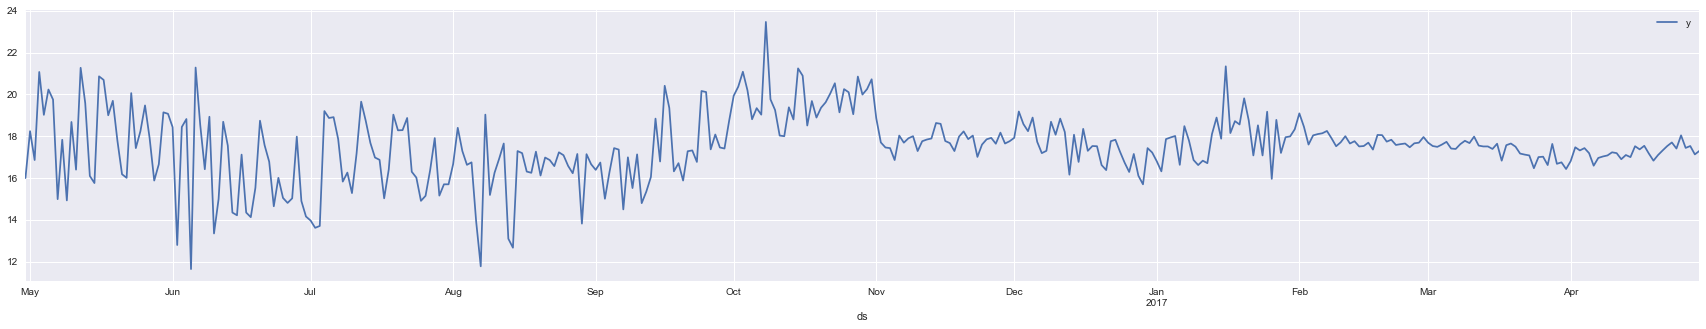

In [153]:
name = input("Which plantform you want to see? ")
df = pd.read_csv('./网贷之家2/'+str(name)+'pic.csv').drop('Unnamed: 0', axis=1)
df['x'] = pd.to_datetime(df['x'])
df_intest_rate = df[['x', '预期利率']].rename(columns={'x': 'ds', '预期利率': 'y'})
# print('the history is:')
df_intest_rate.set_index('ds').plot(figsize=(30, 5));
# print('fit the model')
m = Prophet(growth='linear')  # if growth='logistic', there must be a column of 'cap' in the dataframe sent to fit


In [154]:
m.fit(df_intest_rate)
forecast = m.predict()

Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


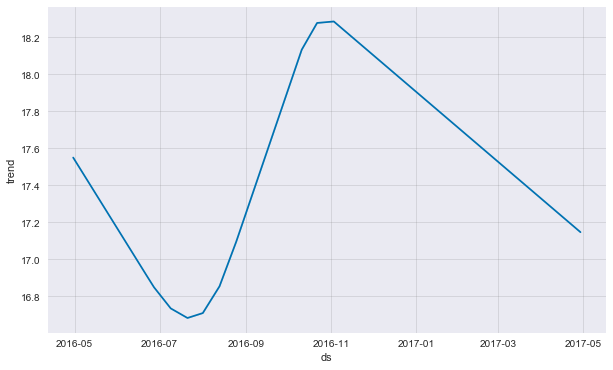

In [155]:
m.plot_trend(forecast);

In [158]:
e=np.array([[1, 2, 5],

       [1, 3, -2],

       [2, 5, 3]])
np.linalg.det(e)



0.0

In [159]:
def add(x):
    if(x==1):
        return 1
    else:
        return x+add(x-1)
add(5)

15

In [164]:
def removeDuplicate(s):
    new_s = ""
    count = 0 
    previous_num = 0
    for i in range(0,len(s)-1):
        next_num = i+1
        if s[previous_num]==s[next_num]: 
            count = count + 1
            if i ==len(s)-2:
                new_s = new_s + s[previous_num]
        else: 
            new_s = new_s + s[previous_num]
            previous_num = next_num
    return (new_s,count)

print(removeDuplicate('daabbdsss'))

('dabds', 4)


In [165]:
import random
zongshu = 10000000
jishu = 0
for i in range(zongshu) :
    x = random.random()
    y = random.random()
    if (x ** 2 + y ** 2) < 1 :
        jishu+=1
print(jishu * 4.0 / zongshu)

3.1415932


In [166]:
x=1.2
x ** 2 


1.44